## Install the PGR-TK package

If neccessary, install the package into your python environment 
```
pip install --force /code/pgrtk-0.3.2-cp38-cp38-linux_x86_64.whl
```

In [1]:
import pgrtk
import os
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

In [2]:
pgrtk.__version__

'pgrtk 0.3.2 (main:00d8eb3, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [3]:
os.chdir("/results")

## Lazy load the the AGCfile for fetching sequences

In [4]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc") # lazy load an agc file of the reference without any SHIMMER index 

## Load the index into memory
The loads the index into the memory. It takes about one minute.

In [5]:
%%time
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/data/pgr-tk-HGRP-y1-evaluation-set-v0")

CPU times: user 19.7 s, sys: 2min 20s, total: 2min 40s
Wall time: 2min 2s


We can see the specification about how SHIMMERs are computed using the `get_shmmr_spec()` method. 

In [6]:
sdb.get_shmmr_spec() # window_size, k_mer_size, hieraical_reduction_factor, min_span, use_k_mer_sketch_other_than_minimizer

(80, 56, 4, 64, False)

## Query the database with HLA-Class II region sequences 

We use a copy of the annotation for IGV hg19 to look up the chromosome and locations of the gene of interest.
We can fetch the region of interest with `ref_db`. Let's fetch the whole region and do a dot plot to examine the repeat structure. 

49


(0.0, 828999.0)

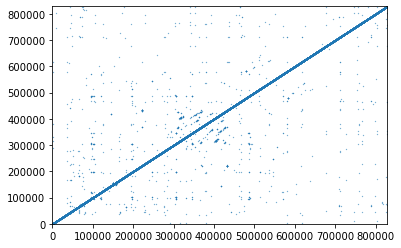

In [7]:
ref_file_name, roi_chr, roi_b, roi_e = 'hg19_tagged.fa', "chr6_hg19", 32130918, 32959917
padding = 0

#get a segment of a reference
roi_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b-padding, roi_e+padding)
x, y = pgrtk.get_shmmr_dots(roi_seq, roi_seq, 32, 32, 2, 2)
plt.plot(x, y, ".", markersize=0.5)
print(x[0])
plt.xlim(0,len(roi_seq))
plt.ylim(0,len(roi_seq))

In [8]:
#find hits in the pangenomic reference
aln_range = pgrtk.query_sdb(sdb, roi_seq, merge_range_tol=200000)

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 114
The total aligned regions is 147


We can examine, the target region sizes.

In [9]:
rgn_lengths = []
for k in list(aln_range.keys()):
    b, e = aln_range[k][0][0:2]
    print(sdb.seq_info[k], "target region", b, "-", e, "len:", e-b )
    rgn_lengths.append(e-b)

('HG02818#1#JAHEOS010000026.1', 'HG02818.paternal.f1_assembly_v2_genbank.fa', 27438479) target region 3503365 - 4325934 len: 822569
('HG02886#1#JAHAOU010000006.1', 'HG02886.paternal.f1_assembly_v2_genbank.fa', 55496981) target region 22522980 - 23317712 len: 794732
('chr6_GL000250v2_alt_hg38', 'hg38_tagged.fa', 4672374) target region 3497464 - 3812023 len: 314559
('HG03453#2#JAGYVV010000230.1', 'HG03453.maternal.f1_assembly_v2_genbank.fa', 5546504) target region 3402532 - 4193513 len: 790981
('HG02145#1#JAHKSG010000017.1', 'HG02145.paternal.f1_assembly_v2_genbank.fa', 11219473) target region 6953506 - 7772155 len: 818649
('HG01175#2#JAHALZ010000032.1', 'HG01175.maternal.f1_assembly_v2_genbank.fa', 31257284) target region 23360059 - 24179654 len: 819595
('HG00733#1#JAHEPQ010000070.1', 'HG00733.paternal.f1_assembly_v2_genbank.fa', 39879370) target region 32136286 - 32923993 len: 787707
('HG03453#1#JAGYVW010000148.1', 'HG03453.paternal.f1_assembly_v2_genbank.fa', 5669647) target region 13

Text(0, 0.5, 'count')

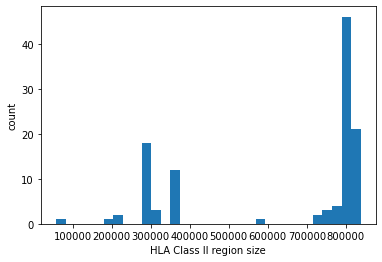

In [10]:
plt.hist(rgn_lengths, bins=32);
plt.xlabel("HLA Class II region size")
plt.ylabel("count")

Some mapped regions are larger, let's check the repeat / CNV by quick dot plots

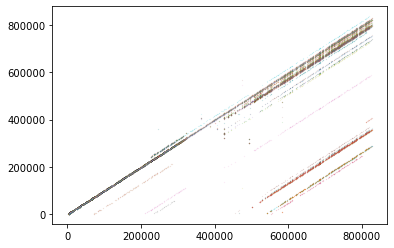

In [11]:
seq_list = []
i = 0
seq_info = sdb.seq_info.copy()
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
   
    for rgn in rgns:
        b, e, length, orientation, aln = rgn

        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
       
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append((i, "{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        x, y = pgrtk.get_shmmr_dots(roi_seq, seq, 80, 56, 12, 1)
        plt.plot(x, y, ".", markersize=0.1)
        i += 1



## Create a new shimmer database for the detailed study

In [12]:
seq_list = []
i = 0
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
    
    rgns = pgrtk.merge_regions(rgns,tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
 
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        i += 1



Create a shimmer indext database with smaller window (denser shimmers)

In [13]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=12, min_span=18)

In [14]:
len(new_sdb.seq_info)

147

In [15]:
#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(new_sdb, roi_seq, merge_range_tol=300000)

aln_range = aln_range0

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 147
The total aligned regions is 147


Let's loop through the hits (contigs that has alignments) and see the number of "copies".

In [16]:
from collections import Counter

In [17]:
n_copy = {}
for k in list(aln_range.keys()):
    n_copy[k] = len(aln_range[k])
copy_count = Counter(n_copy.values())
for nc, nh in copy_count.items():
    print("number of copy: {}, number of haplotypes: {}".format(nc, nh))

number of copy: 1, number of haplotypes: 147


Text(0, 0.5, 'count')

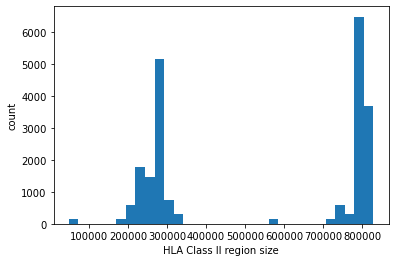

In [18]:
rgn_lengths = []
for k in list(aln_range.keys()):
    for sid, rgns in aln_range.items():
        for rgn in rgns:
            b, e = rgn[0:2]
            #print(seq_index[k], "target region", b, "-", e, "len:", e-b )
            rgn_lengths.append(e-b)
plt.hist(rgn_lengths, bins=32);
plt.xlabel("HLA Class II region size")
plt.ylabel("count")

In [19]:
f0 = open("/results/HLA-Class2_seq.fa", "w")
for sid in aln_range:
    rgns = aln_range[sid]
    c, s, _ = new_sdb.seq_info[sid]
    print(c, s)
    count = 0
    for rgn in rgns:
        b, e, l, orientation, alns = rgn
        seq = new_sdb.get_sub_seq(s, c, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
        
        print(">{}_{}_{} {}".format(c, b, e, s), file=f0)
        print(pgrtk.u8_to_string(seq), file=f0)
       
f0.close()

HG02818#1#JAHEOS010000026.1_3503365_4325934_0 Memory
HG02148#2#JAHAMF010000034.1_3417861_4208964_0 Memory
HG02257#1#JAGYVI010000022.1_27484494_28280971_1 Memory
chr6_GL000256v2_alt_hg38_3481069_3778827_0 Memory
HG00621#1#JAHBCD010000020.1_23360091_23711816_1 Memory
HG02818#2#JAHEOR010000019.1_16915483_17713098_1 Memory
HG01928#1#JAGYVQ010000020.1_27374381_27732067_1 Memory
HG02145#2#JAHKSF010000005.1_3502917_4318859_0 Memory
HG01123#1#JAGYYZ010000057.1_25895025_26182990_1 Memory
HG01361#2#JAGYYW010000059.1_32800632_33087679_0 Memory
chr6_ssto_hap7_hg19_4032775_4439545_0 Memory
HG00733#1#JAHEPQ010000070.1_32136286_32923993_0 Memory
HG02486#2#JAGYVL010000026.1_32112628_32907289_0 Memory
HG00733#2#JAHEPP010000166.1_5000_204370_1 Memory
chr6_GL000254v2_alt_hg38_3506514_4277282_0 Memory
HG005#2#JAHEPN010000064.1_7595432_7953375_0 Memory
HG02630#2#JAHAOP010000058.1_23131055_23500654_1 Memory
HG02622#2#JAHAON010000041.1_32704698_33060395_0 Memory
NA20129#1#JAHEPE010000077.1_3426335_4225737_0 

In [20]:
help(new_sdb.generate_mapg_gfa)

Help on built-in function generate_mapg_gfa:

generate_mapg_gfa(...) method of builtins.SeqIndexDB instance
    Convert the adjecent list of the shimmer graph shimmer_pair -> GFA
    
    Parameters
    ----------
    min_count : int
        the minimum number of times a pair of shimmers must be observed to be included in the graph
    
    filenpath : string
        the path to the output file
    
    Returns
    -------
    
    None
        The data is written into the file at filepath



In [21]:
new_sdb.generate_mapg_gfa(0, "/results/HLA-ClassII.gfa")

## Construct the genome graphs

In [22]:
import networkx as nx
from networkx.drawing import nx_pydot 

In [23]:
def get_graph(seq_list, w=128, k=56, r=4, min_span=1, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=8)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        if sid != highlite:
            continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "blue"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_node(v, fillcolor=color, style="filled")
            G.add_edge(v, w, penwidth = penwidth, color=color )
            v = w
    return G
    

In [24]:
def get_graph2(seq_list, w=128, k=56, r=4, min_span=1, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=8)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  1 + 0.03 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        if sid != highlite:
            continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "blue"
            penwidth =  1 + 0.05 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_node(v, fillcolor=color, style="filled")
            G.add_edge(v, w, penwidth = penwidth, color=color )
            G.add_edge(w, v, penwidth = penwidth, color=color )
            v = w
    return G
    

In [25]:
for ht in (0, 1, 2, 5,):
    w=128; k=56; r=12;
    name="HLA-ClassII"
    G = get_graph2(seq_list, w=w, k=k, r=r, highlite=ht)
    
    #nx.write_gexf(G, f"/results/{name}-{w}-{k}-{r}.gexf")
    
    ## very slow for graphviz to layout, remove comment to execute
    
    #nx_pydot.write_dot(G, f"{name}-{w}-{k}-{r}.dot")
    
    ## for this version of graphviz, we need to create PDF to get the bounding box right
    
    #os.system(f"""neato -Tpdf {name}-{w}-{k}-{r}.dot -x -Grankdir=LR -Gsize=64,64 \
    #-Nfixedsize=true -Nwidth=.5 -Nheight=.5 -Nlabel="" > {name}-{w}-{k}-{r}-h{ht}.pdf""")
    #os.system(f"""pdf2svg {name}-{w}-{k}-{r}-h{ht}.pdf {name}-{w}-{k}-{r}-h{ht}.svg""")

In [26]:
for r in (2, 8, 12):
    w=128; k=32;
    name="HLA-ClassII"
    
    G = get_graph(seq_list, w=w, k=k, r=r, highlite=83)
    
    ## very slow for graphviz to layout, remove comment to execute
    
    #nx_pydot.write_dot(G, f"{name}-{w}-{k}-{r}.dot")
    
    ## for this version of graphviz, we need to create PDF to get the bounding box right
    #os.system(f"""dot -Tpdf {name}-{w}-{k}-{r}.dot -x -Grankdir=LR -Gsize=64,64 \
    
    #-Nfixedsize=true -Nwidth=.5 -Nheight=.5 -Nlabel="" > {name}-{w}-{k}-{r}.pdf""")
    #os.system(f"""pdf2svg {name}-{w}-{k}-{r}.pdf {name}-{w}-{k}-{r}.svg""")